<a href="https://colab.research.google.com/github/Sruthi-Sami/stress-prediction/blob/main/stress_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd
import numpy as np

data=pd.read_csv('HackWave_Final_StressLevelDataset.csv')


In [ ]:
data.shape

(1100, 15)

In [ ]:
data.head()


,anxiety_level,mental_health_history,headache,bpm,sleep_duration,academic_performace,financial_condition,safety,screen_time,extracurricular_activities,Gender,blood_oxygen_spo2,stress_level,step_count,bmi
0,14,0,2,67,4.0,3,2,3,3,3,0,97,1,3656,27
1,15,1,5,84,1.0,2,2,1,5,5,1,90,2,4110,24
2,12,1,2,67,3.0,3,2,2,2,2,1,95,1,3505,26
3,16,1,4,85,2.0,2,2,2,4,4,1,92,3,6762,20
4,16,0,2,81,8.0,4,3,4,2,0,0,94,1,4794,22


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
X = data.drop(columns=['stress_level'], axis=1)
y = data['stress_level']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test


In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
grid_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=5)
grid_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_rf.best_params_)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:

rf = RandomForestClassifier(max_depth=None,min_samples_leaf=2,min_samples_split=2,n_estimators=50)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, n_estimators=50)

In [ ]:
cv_rf = cross_val_score(rf, X_train, y_train, cv=5)

In [ ]:
print("Random Forest CV Scores:", cv_rf)


Random Forest CV Scores: [0.92613636 0.88068182 0.89204545 0.86931818 0.85227273]


In [ ]:
y_pred = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm

Random Forest Accuracy: 0.8818181818181818


array([[70,  4,  2,  0],
       [ 8, 64,  1,  0],
       [ 7,  2,  8,  0],
       [ 2,  0,  0, 52]])

In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.92      0.86        76
           1       0.91      0.88      0.90        73
           2       0.73      0.47      0.57        17
           3       1.00      0.96      0.98        54

    accuracy                           0.88       220
   macro avg       0.86      0.81      0.83       220
weighted avg       0.88      0.88      0.88       220



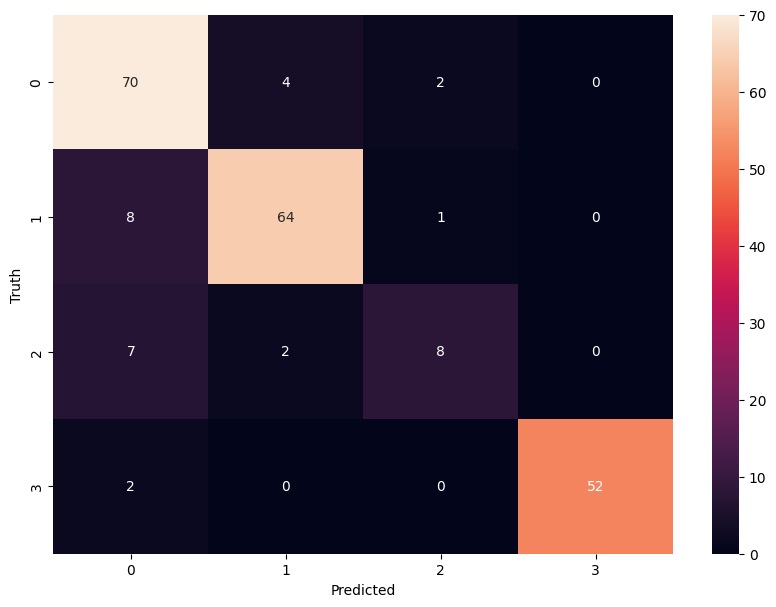

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

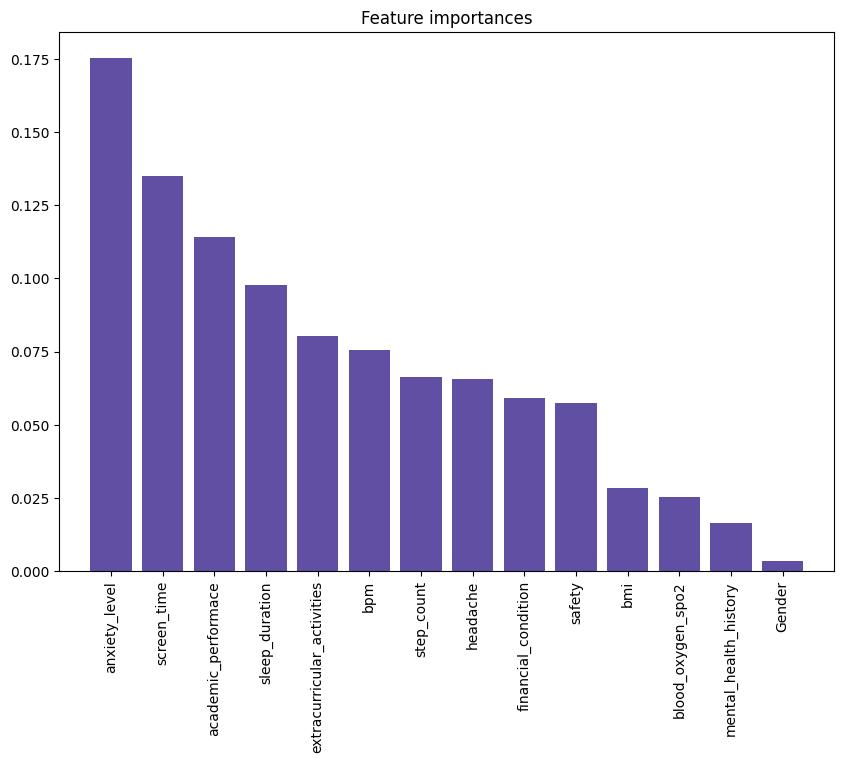

In [ ]:

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,7))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="#614FA3", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

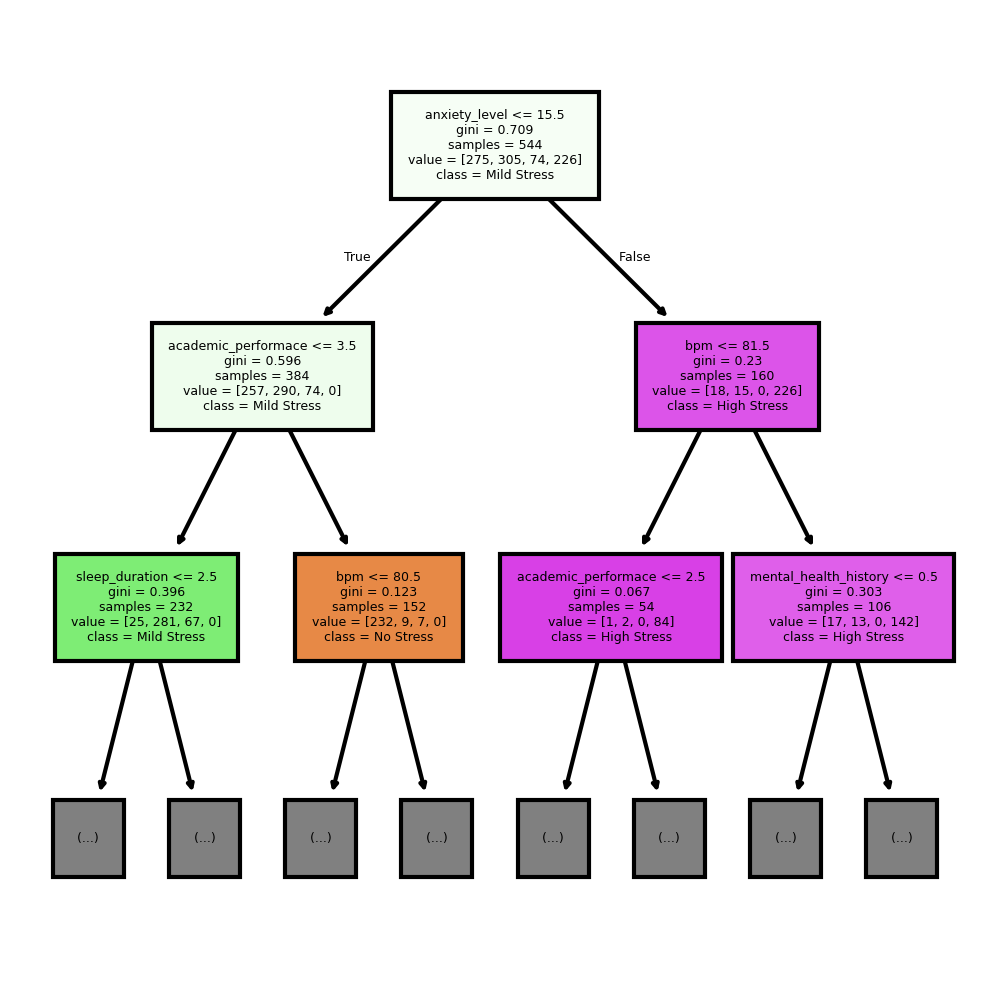

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract single tree
estimator = rf.estimators_[5]

# Create a figure
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi=300)

# Plot tree
plot_tree(estimator,
          feature_names = X.columns,
          class_names=["No Stress", "Mild Stress", "Moderate Stress","High Stress"],
          filled = True,
          max_depth = 2,
          fontsize=3)

plt.show()

In [ ]:
y_pred = rf.predict(X_test)


In [ ]:
y_pred[0]

np.int64(3)

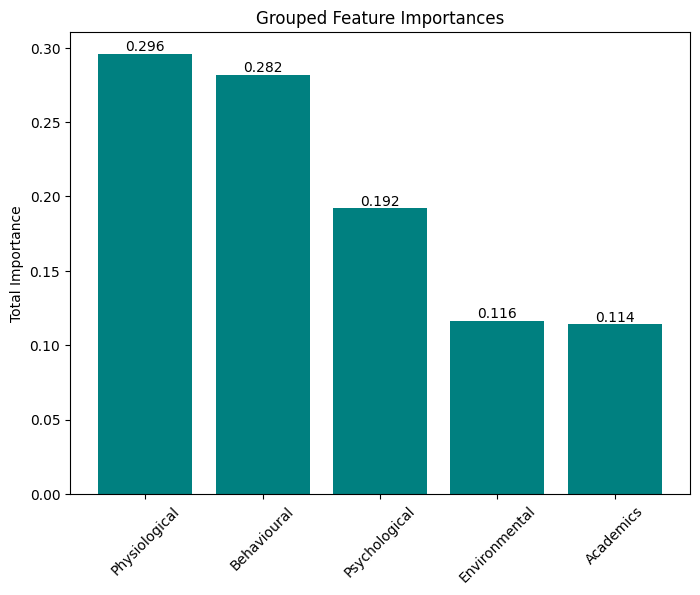

In [ ]:
# Define your groups with actual feature names
feature_groups = {
    "Physiological": ["sleep_duration", "headache", "bpm", "Gender", "blood_oxygen_spo2", "bmi"],
    "Psychological": ["anxiety_level", "mental_health_history"],
    "Behavioural": ["screen_time", "extracurricular_activities", "step_count"],
    "Academics": ["academic_performace"],
    "Environmental": ["safety", "financial_condition"],

}

# Convert feature importances to a DataFrame
feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
})

# Aggregate per group
grouped_importance = {}
for group, features in feature_groups.items():
    grouped_importance[group] = feat_imp[feat_imp["Feature"].isin(features)]["Importance"].sum()

# Turn into DataFrame
grouped_df = pd.DataFrame({
    "Group": list(grouped_importance.keys()),
    "Importance": list(grouped_importance.values())
}).sort_values("Importance", ascending=False)

# Plot grouped importance
plt.figure(figsize=(8,6))
plt.title("Grouped Feature Importances")
bars = plt.bar(grouped_df["Group"], grouped_df["Importance"], color="teal")
plt.xticks(rotation=45)
plt.ylabel("Total Importance")

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   # x position (center of bar)
        height,                            # y position (top of bar)
        f"{height:.3f}",                   # label (3 decimals)
        ha="center", va="bottom"           # align center
    )

plt.show()


In [ ]:
import joblib

# Save your trained Random Forest model
joblib.dump(rf, "classifier.joblib")

print("✅ Classifier model saved as classifier.joblib")


✅ Classifier model saved as classifier.joblib


In [ ]:
from google.colab import files
files.download("classifier.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>